# Support Vector Machines

In this notebook we will develop support vector machine models for several datasets by using them to formulate a constrained optimisation problem. First, we review how constrained optimisation is done in Python using [cvxpy](https://www.cvxpy.org).

## Constrained Optimisation

Consider the problem of minimising $x^2+y^2$ subject to the constraints $3x+2y>=7$ and $x+2y>=6$. Here is a visualisation of the solution along with the constraints and the function we are trying to minimise.

<div>
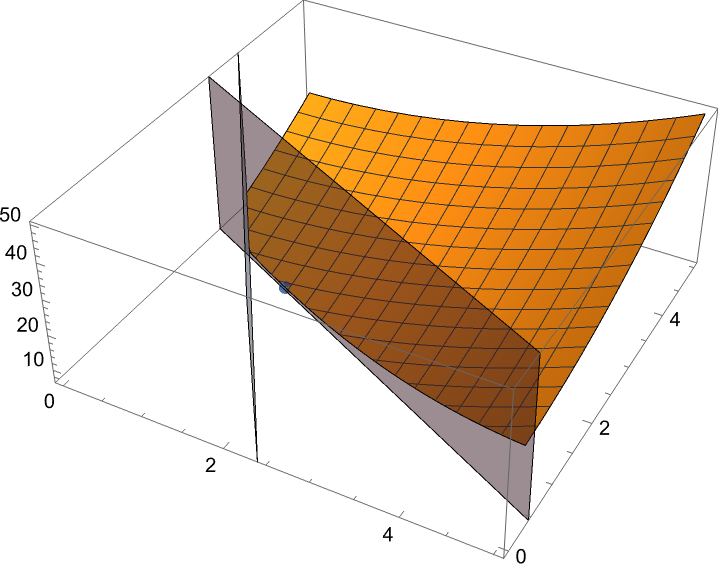
</div>

Let's now solve this problem using cvxpy:

In [1]:
import cvxpy as cp

In [2]:
# Create two scalar optimization variables.
x = cp.Variable()
y = cp.Variable()

# Create two constraints.
constraints = [3*x + 2*y >= 7,
               x + 2*y >= 6]

# Form objective.
obj = cp.Minimize(cp.sum([cp.square(x), cp.square(y)]))

# Form and solve problem.
prob = cp.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value, y.value)

status: optimal
optimal value 7.199999999999999
optimal var 1.2 2.4


## Linear Support Vector Machine

Let's now produce a support vector machine with some sample data. First, we need to define the samples, $x_i$. These are points in a 2D vector space which are labelled as either "Plus" or "Minus".

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [101]:
plus = np.array([[1.284422952732416,  2.481901856407326],
               [1.4879960382523703, 2.402086883623099],
               [4.193340935618989,  2.0674820899685353],
               [1.07511361074236,   2.8655605261563037],
               [4.5621522276001985, 2.3036590135818598],
               [0.0734941576442104, 2.7567100412409644],
               [2.0267587486366514, 1.8146817202743937],
               [1.7160467347301873, 2.2314527869285374]])

minus = np.array([[0.3650725217541822, 1.4540111456859945],
                  [1.8799169703454597, 1.3235540770631689],
                  [0.2775167301897557, 0.026781782266628973],
                  [1.7185797382262036, 0.8439744313421516],
                  [1.0440125841941863, 0.8714161830961258],
                  [4.009012707820185,  0.4883132746354524],
                  [0.0444111436444237, 1.0249991478151106],
                  [1.4175016236764821, 0.3949618274790252],
                  [0.4028778285168028, 0.35796696425588426],
                  [1.3129335119181957, 0.193320544474747],
                  [1.6678854129083547, 0.5245058562945744],
                  [3.62477502445507,   0.2321920742831569]])

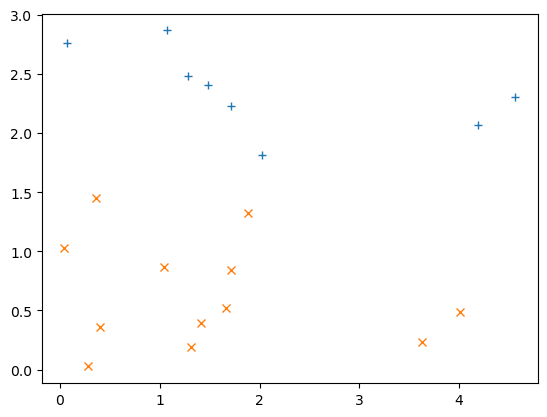

In [103]:
plt.plot(plus[:,0],plus[:,1],'+')
plt.plot(minus[:,0],minus[:,1],'x')
plt.show()

### Solving the primal problem

We will now use cvxpy to solve the primal optimisation problem. We just need to set up the objective and the constraints, then ask it to solve.

In [172]:
w = cp.Variable(2)
b = cp.Variable()

First, we need to set up the constraints imposed by the samples.

In [173]:
constraints = [plus@w+b >= +1, minus@w+b <= -1]

Now we can use `Minimise` to set the objective

In [174]:
objective = cp.Minimize(cp.sum(cp.square(w)))

Finally, we find the  solution to the constrained optimisation problem.

In [175]:
# Form and solve problem.
prob = cp.Problem(objective, constraints)

# Solve the minimisation and return the optimal value.
prob.solve()

15.22250334821028

In [176]:
print("status:", prob.status)
print("optimal value:", prob.value)
print("optimal var:", w.value, b.value)

status: optimal
optimal value: 15.22250334821028
optimal var: [1.11764973 3.7380961 ] -8.04866102501868


In [181]:
(w1, w2) = w.value
b0 = b.value

Now define a decision function $d(x)$ that takes in a new point and decides if it is a plus or minus

In [182]:
def decision(x):
    w = np.array([w1, w2])
    if w@x + b0 > 0:
        return "Plus"
    else:
        return "Minus"

In [183]:
decision([2,2])

'Plus'

Our margins and decision line are given by solving $w^T x + b= \{-1, 0, 1\}$, ie.
$$ x_2 = \frac{- x_1 w_1 - b + \{-1,0,1\}}{w_2}$$
Let's use this to plot our decision line, margins and data points:

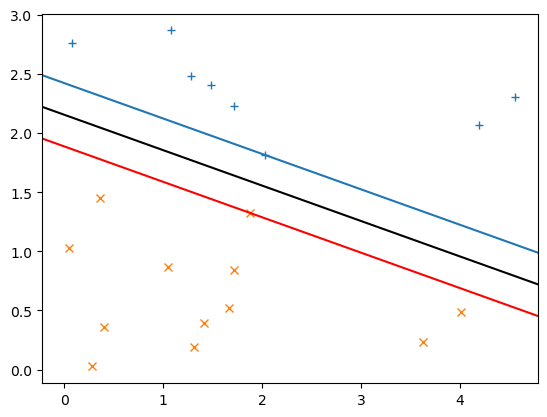

In [184]:
plt.plot(plus[:,0],plus[:,1],'+')
plt.plot(minus[:,0],minus[:,1],'x')
plt.axline([0,(-b0+(+1))/w2], [1,(-w1-b0+(+1))/w2])
plt.axline([0,(-b0+(-1))/w2], [1,(-w1-b0+(-1))/w2], c='r')
plt.axline([0,(-b0+(0))/w2], [1,(-w1-b0+(0))/w2], c='k')
plt.show()

### Solving the dual problem

We could also solve the dual problem. First, we build up the matrix $X$ and vectors $y$, $\lambda$ and $e$.

In [185]:
X = np.concatenate((plus, -minus))
y = np.concatenate((np.full(plus.shape[0],+1), np.full(minus.shape[0], -1)))
N = y.shape
e = np.ones(N)

Now we can solve the dual optimisation problem (here we explicitly tell cvxpy that $X X^T$ is positive semi-definite by setting `assume_PSD = True`)

In [186]:
lam = cp.Variable(N)

obj = cp.Minimize(0.5*cp.quad_form(lam, X@X.T,assume_PSD=True) - e @ lam)

prob = cp.Problem(obj,
                 [y.T @ lam == 0,
                  lam >= 0])

prob.solve()

-7.611251674105144

Notice that only a small number of the $\lambda_i$ are non-zero; these are the ones corresponding to the support vectors.

In [187]:
print("status:", prob.status)
print("optimal value:", prob.value)
print("optimal var:", lam.value)

status: optimal
optimal value: -7.611251674105144
optimal var: [-1.74192812e-20 -2.08590230e-20 -2.20626968e-20 -2.08826123e-20
 -2.23020082e-20 -4.02003373e-21  7.61125167e+00 -1.81056771e-20
 -9.42334445e-20  7.61125167e+00 -5.82022612e-19 -4.65659566e-20
 -1.01646361e-19  1.35351780e-21 -2.36261375e-19 -1.14726916e-19
 -3.41691254e-19 -1.51881077e-19 -7.73169740e-20 -6.50978369e-21]


We can next compute the value for $w=X^T \lambda$ and find $b$ from one of the constraints with a non-zero $\lambda_i$ actually being an equality (rather than an inequality).

In [188]:
(w1_dual, w2_dual) = X.T@lam.value

sv = lam.value.argmax()
b_dual = y[sv]-([w1_dual, w2_dual]@X[sv]/y[sv])

(w1_dual, w2_dual, b_dual)

(1.11764973084742, 3.738096096590793, -8.048661025018761)

Check this agrees with what we found when solving the primal version.

In [192]:
(w1,w2,b0)

(1.1176497308474065, 3.7380960965907497, array(-8.04866103))

Knowing the support vectors, we could also go the other way and obtain the $\lambda$'s from the $w$ and $b$ found by solving the primal problem:

In [193]:
np.linalg.inv(np.array([X[6],X[9]]).T)@[w1,w2]

array([7.61125167, 7.61125167])

Again, this is consistent with solving the dual problem.

## Kernel trick

Consider the non-linearly separable data below

In [218]:
plus = np.array([[-0.19418006351395,-0.7939897238477599],[0.0009402659049429163,0.11141564362630568],[0.6985681983270928,-0.36790456437588814],
   [-0.00295604144687557,-0.18777988106197538],[-0.23888242209918228,0.034500797441814446],[-0.02990472311744523,0.05854307847237184],
   [-0.4835702248162677,0.24533902079622932],[0.20390719257284282,0.10887728322031986],[0.10538241515767546,-0.38172681750042337],
   [-0.1824956607100494,-0.6762831160175996]])

minus = np.array([[2.041251388907825,-0.35539451182767],[-0.729497294004517,1.9430725958833286],[-1.9582099623680669,-0.14589014711693948],
   [0.7549130603093653,-1.6895760872115724],[-0.5094375357680065,1.9943197246955076],[-1.8706064275341703,-0.14104829949370085],
   [1.4543618707479875,-1.18363578035018],[1.853565067751745,-0.4895674667312021],[1.9874646392084663,-0.5256987415568544],
   [0.2956806496520435,2.0791324971956673]])

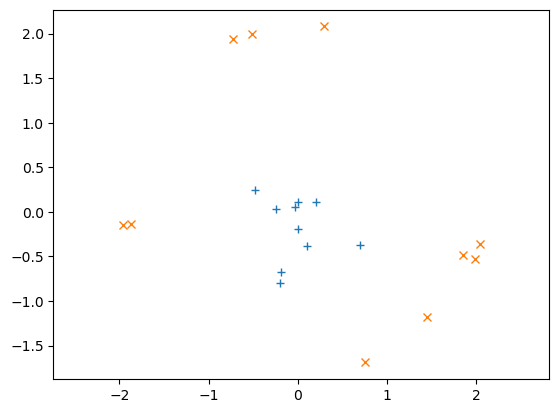

In [261]:
plt.plot(plus[:,0],plus[:,1],'+')
plt.plot(minus[:,0],minus[:,1],'x')
plt.axis('equal')
plt.show()

Use the kernel trick to build a support vector machine in this case in several ways:

- With an explicit polar coordinate map $\phi(x,y)=(r,\theta)$ that will transform the data into a nice form.
- With a map that projects onto a higher dimension: $\phi(x,y)=(x,y,x^2+y^2)$
- With an implicit map using the kernel trick: instead of defining the map explicitly, the fact that our optimisation only depends on the inner product of samples means we can use the kernel trick. Define a kernel $k[(x_i,y_i),(x_j,y_j)]= x_i x_j + y_i y_j + (x_i^2+y_i^2)(x_j^2+y_j^2)$.

### Explicit polar coordinate map

In [262]:
x_p = plus[:,0]
y_p = plus[:,1]
x_m = minus[:,0]
y_m = minus[:,1]

In [263]:
r_p = np.sqrt(x_p**2 + y_p**2)
theta_p = np.arctan2(y_p, x_p)
plus_polar = np.array([r_p, theta_p]).T

r_m = np.sqrt(x_m**2 + y_m**2)
theta_m = np.arctan2(y_m, x_m)
minus_polar = np.array([r_m, theta_m]).T

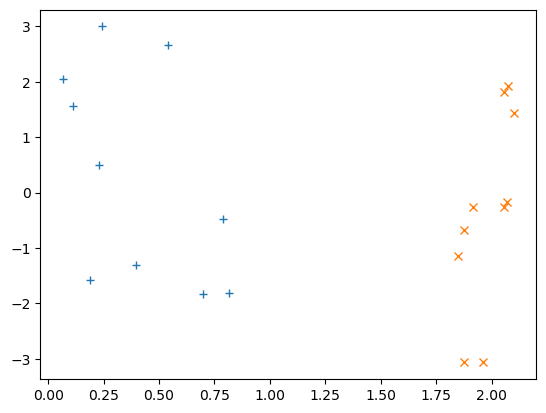

In [264]:
plt.plot(r_p, theta_p,'+')
plt.plot(r_m, theta_m,'x')
plt.show()

In [265]:
X = np.concatenate((plus_polar, -minus_polar))
y = np.concatenate((np.full(plus_polar.shape[0],+1), np.full(minus_polar.shape[0], -1)))
N = y.shape
e = np.ones(N)

lam = cp.Variable(N)

obj = cp.Minimize(0.5*cp.quad_form(lam, X@X.T,assume_PSD=True) - e @ lam)

prob = cp.Problem(obj,
                 [y.T @ lam == 0,
                  lam >= 0])

prob.solve()

-1.84267996159001

In [266]:
print("status:", prob.status)
print("optimal value:", prob.value)
print("optimal var:", lam.value)

status: optimal
optimal value: -1.84267996159001
optimal var: [ 1.84267996e+00 -2.85761040e-23 -7.36669117e-22 -7.62563778e-22
  7.49839844e-23 -2.19543046e-22  2.00347243e-22 -8.31130666e-22
  5.36040552e-23 -5.90570409e-22 -2.33952292e-22 -3.17128924e-22
 -4.73318568e-23  1.22106392e+00 -2.78638594e-22  6.21616043e-01
 -1.43886642e-22 -3.53062800e-22 -6.97292606e-22 -4.13993601e-22]


In [271]:
(w1, w2) = X.T@lam.value

sv = lam.value.argmax()
b = y[sv]-([w1, w2]@X[sv]/y[sv])

(w1, w2, b)

(-1.919560949540894, -0.025410316363612573, 2.523019736898089)

Now let's plot the decision line in the $r-\theta$ coordinates

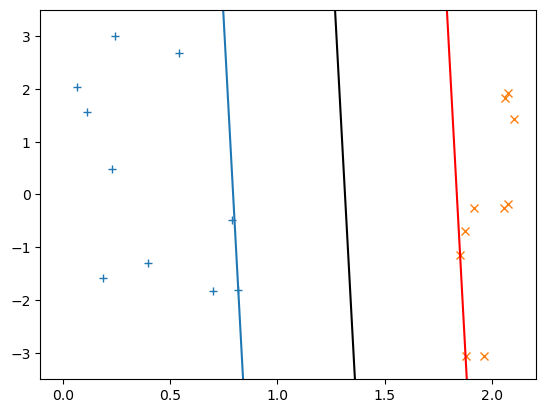

In [272]:
plt.plot(r_p, theta_p,'+')
plt.plot(r_m, theta_m,'x')
plt.axline([0,(-b+(+1))/w2], [1,(-w1-b+(+1))/w2])
plt.axline([0,(-b+(-1))/w2], [1,(-w1-b+(-1))/w2], c='r')
plt.axline([0,(-b+(0))/w2], [1,(-w1-b+(0))/w2], c='k')
plt.ylim((-3.5,3.5))
plt.show()

We can also draw them on the original plot

In [295]:
theta = np.linspace(-np.pi, np.pi, 100)
r_plus = (-w2*theta-b+(+1))/w1
r_minus = (-w2*theta-b+(-1))/w1
r_d = (-w2*theta-b+(0))/w1

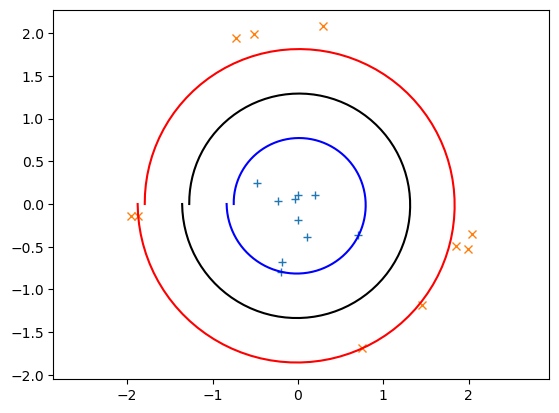

In [300]:
plt.plot(x_p, y_p, '+')
plt.plot(x_m, y_m,'x')
plt.plot(r_plus*np.cos(theta),r_plus*np.sin(theta),'b-')
plt.plot(r_minus*np.cos(theta),r_minus*np.sin(theta),'r-')
plt.plot(r_d*np.cos(theta),r_d*np.sin(theta),'k-')
plt.axis('equal')
plt.show()

### Explicit map to higher dimension

Left as an exercise.

### Implicit kernels

In [334]:
def k(x1, x2):
    return x1[0]*x2[0] + x1[1]*x2[1] + (x1[0]**2 + x1[1]**2)*(x2[0]**2 + x2[1]**2) 

In [335]:
X = np.concatenate((plus, minus))
y = np.concatenate((np.full(plus.shape[0],+1), np.full(minus.shape[0], -1)))
N = y.shape
e = np.ones(N)

In [336]:
XXT = np.array([[k(x1, x2) for x1 in X] for x2 in X])

In [337]:

lam = cp.Variable(N)

obj = cp.Minimize(0.5*cp.quad_form(cp.multiply(y,lam), XXT, assume_PSD = True) - e @ lam)

prob = cp.Problem(obj,
                 [y.T @ lam == 0,
                  lam >= 0])

prob.solve()

-0.2533846673072002

In [338]:
lam.value*y

array([ 2.53384667e-01,  4.78783420e-20,  4.69426328e-20,  3.32871722e-20,
        3.74279466e-20,  4.45549006e-20,  4.16296467e-20,  5.40516838e-20,
        2.72087775e-20,  5.88372849e-21,  9.87075997e-20,  1.31051106e-19,
       -5.11993368e-21, -1.54806366e-01,  1.41640936e-19, -9.85783012e-02,
        4.03542878e-20,  8.63020948e-20,  9.03624659e-20,  1.69306878e-19])

We have now found the solution. In fact, it's the exact same solution as we found with the 3D map because this kernel is exactly the one you get from that map.

We next find b from one of the constraints with a non-zero $\lambda_i$ actually being an equality (rather than inequality).

In [339]:
b = 1 - (y*lam.value)@[k(xi,X[0]) for xi in X]
b

1.5354036632692696

Now we draw our decision line and margins on the original plot

In [340]:
def decision(x):
    return (y*lam.value)@[k(xi, x) for xi in X] + b

In [351]:
xx = np.linspace(-2, 2, 100)
yy = np.linspace(-2, 2, 100)
h = [[decision([x,y]) for x in xx] for y in yy]

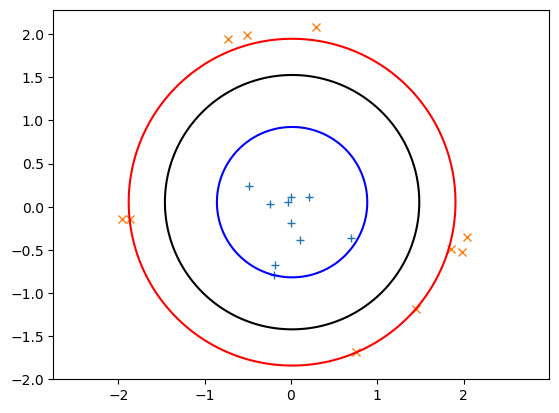

In [356]:
plt.plot(x_p, y_p, '+')
plt.plot(x_m, y_m,'x')
plt.contour(xx, yy, h, levels=[-1,0,1], colors=['r', 'k', 'b'])
plt.axis('equal')
plt.show()

## Example: Handwriting recognition

A nice example of the power of support vector machines is in [handwriting recognition](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html).